# NAIAD Tutorial

In this tutorial, we'll walk through the core steps for training NAIAD models on genetic perturbation data and evaluating their performance. We will cover:

1. **NAIAD model and workflow**: How to train a model using genetic perturbation data and predict novel perturbations.  
2. **Model performance evaluation**: How NAIAD’s predictive accuracy changes when we start from small number of training data (including replicates).

We'll use the [Norman2019](https://www.science.org/doi/10.1126/science.aax4438) dataset as our primary example. This dataset provides cell viability measurements for pairwise CRISPRa perturbations across approximately 120 genes.

For further exploration, we can also apply the same workflow to the [Simpson2023](https://www.biorxiv.org/content/10.1101/2023.08.19.553986v1) and [Horlbeck2018](https://www.cell.com/cell/fulltext/S0092-8674(18)30735-9) datasets, both located in the `./data` subfolder of this `tutorials` directory.

## Set up notebook

In [34]:
import logging
import numpy as np
import pandas as pd
import torch
import tqdm 
import seaborn as sns
import matplotlib.pyplot as plt
from naiad import load_naiad_data, NAIAD
import naiad
# set some configuration settings for the notebook
logging.basicConfig(level=logging.WARN)
pd.set_option("mode.copy_on_write", True)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')

## NAIAD model and workflow

In this example, we used 500 gene pairs for training, 1,000 for validation, and 1,000 for testing. Alternatively, you can specify fractions for the training, validation, and test sets, and the `NAIAD` function will automatically handle the data splitting.

In [35]:
# provide path to relevant data directories
data_file = './data/norman_gamma.csv'
result_dir = './results/naiad'

# parameters for initializing and running model
device = (
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)
seed = 42
n_epoch = 100

# set up how to split data
n_train = 500 
n_val = 1000
n_test = 1000

emb_model = 'transformer-cls'

Once your preprocessed table data is ready, create a NAIAD object using the `NAIAD` function. This function automatically shuffles the data, splits it into training, validation, and test sets, and generates the corresponding dataloaders. We can then access these data splits through `naiad_model.data`, preserving the same ordering used by the dataloaders. To learn more about the `NAIAD` function, refer to `help(NAIAD)`.

In [36]:
# load data
processed_data = load_naiad_data(data_file)
processed_data.head()


,gene1,gene2,comb_score,g1_score,g2_score
0,AHR,AHR,-0.413976,-0.333858,-0.333858
1,AHR,ARID1A,-0.545311,-0.333858,-0.319112
2,ARRDC3,AHR,-0.409793,-0.126237,-0.333858
3,ATL1,AHR,-0.569601,-0.425927,-0.333858
4,BAK1,AHR,-0.563096,-0.415906,-0.333858


In [37]:
# create the NAIAD object
naiad_model = NAIAD(processed_data, n_train=n_train, n_val=n_val, n_test=n_test )
naiad_model.set_seed(seed=seed)
naiad_model.prepare_data()

In [38]:
print(naiad_model.data.keys())
naiad_model.data['train'].head()

dict_keys(['train', 'val', 'test'])


,gene1,gene2,comb_score,g1_score,g2_score
2248,CLDN6,FOXF1,-0.422906,-0.259578,-0.219357
169,ARID1A,KMT2A,-0.389778,-0.319112,-0.084567
5793,UBASH3A,PRDM1,-0.522684,-0.081235,-0.464206
5454,TBX3,MIDN,-0.344910,-0.089798,-0.274154
2603,HES7,COL2A1,-0.513641,-0.479598,-0.352872


In [39]:
naiad_model.dataloaders   

{'train': <torch.utils.data.dataloader.DataLoader at 0x3c847dfd0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x3c847df70>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x3c847dcd0>}

To initialize the model parameters, we can call `naiad_model.initialize_model`. We can explore the available parameter options by using `help(naiad.models.NAIADEmbedPheno)`. Customize model parameters by providing a dictionary to the `model_args` argument, and configure the optimizer and loss function with `naiad_model.setup_trainer`. Finally, we could train the model using `naiad_model.train_model`.

In [40]:
# initialize model and prepare trainer
naiad_model.initialize_model(device=device, model_args={'embed_model': emb_model})
naiad_model.setup_trainer(n_epoch=n_epoch)

In [41]:
# run model training
naiad_model.train_model(ranking_model = False)

After training the model, we could use the model to generate the prediction for training, validation and test data by naiad_model.generate_preds. We could use the best model based on the validation loss or use the model from the last epoch. The default setting is to use last epoch. 

In [42]:
# generate predictions using the best model based on the validation loss
naiad_model.generate_preds(use_best=True)

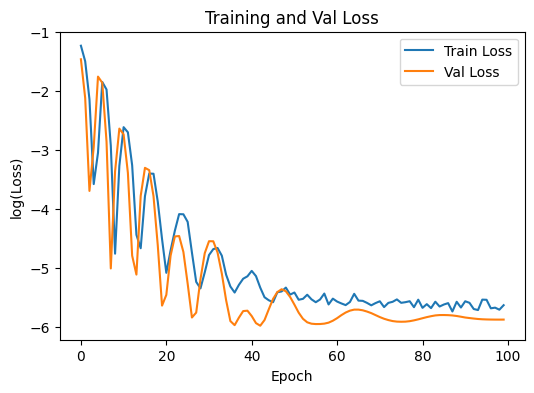

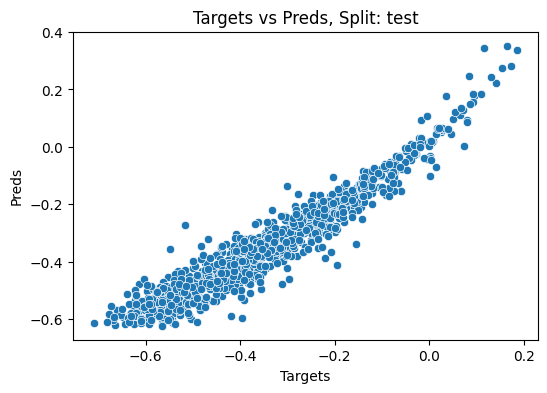

In [43]:
# plot results
fig = naiad_model.plot_loss_curves(log=True)
fig = naiad_model.plot_preds('test')

In [44]:
# extract relevant data from object
model = naiad_model.model                 # final model after training
best_model = naiad_model.best_model       # best model after training based on minimum val loss
preds = naiad_model.preds                 # predictions from best model on all data splits
losses = naiad_model.training_metrics     # train / val loss during training process

## Evaluation performance of NAIAD model with the increase of training data
Here, we demonstrate the process of training the model using replicates and evaluating how the size of the training data impacts the model's performance.

In [9]:
from naiad.utils import RunModelsReplicates


def run_model_replicates(n_ensemble,  emb_model_name, n_train_set = range(100, 3000, 200),  n_val = 1000,  n_test = 1000, n_epoch = 100):
    
    loss_metric = pd.DataFrame(columns=['val_loss_mean', 'test_loss_mean', 'val_loss_std', 'test_loss_std'], index=n_train_set, dtype=float)    
    for n_train in tqdm.tqdm(n_train_set):
        naiad_model = NAIAD(processed_data, n_train=n_train, n_val=n_val, n_test=n_test )
        _, rep_loss = RunModelsReplicates(model=naiad_model, n_ensemble=n_ensemble, n_epoch = n_epoch, device=device, model_args={'embed_model': emb_model_name})

        # get the index of the best model based on the validation loss after 50 epochs
        rep_loss_index = list()
        for loss_i in rep_loss:
            loss_i['val_loss'][0:50] = [1]*50
            rep_loss_index.append(np.argmin(loss_i['val_loss']))

        rep_val_loss = np.array([rep_loss[i]['val_loss'][rep_loss_index[i]] for i in range(len(rep_loss)) ])
        rep_test_loss = np.array([rep_loss[i]['test_loss'][rep_loss_index[i]] for i in range(len(rep_loss)) ])
        
        loss_metric.loc[n_train] = [np.mean( rep_val_loss), np.mean(rep_test_loss),\
                                    np.std(rep_val_loss),  np.std(rep_test_loss)]
    return loss_metric


In [10]:
n_rep = 10
loss_mlp = run_model_replicates(n_ensemble=n_rep, emb_model_name='MLP')
loss_multihead = run_model_replicates(n_ensemble=n_rep, emb_model_name='multihead')
loss_transformer  = run_model_replicates(n_ensemble=n_rep, emb_model_name='transformer')
loss_transformer_cls = run_model_replicates(n_ensemble=n_rep, emb_model_name='transformer-cls')
    

100%|██████████| 15/15 [10:55<00:00, 43.73s/it]


In [11]:
## log transformation of mean and std
loss_mlp['test_loss_mean_log'] = np.log(loss_mlp['test_loss_mean'])
loss_mlp['test_loss_std_log'] = np.sqrt(np.log( 1 + (loss_mlp['test_loss_std']/loss_mlp['test_loss_mean']) **2))

loss_multihead['test_loss_mean_log'] = np.log(loss_multihead['test_loss_mean'])
loss_multihead['test_loss_std_log'] = np.sqrt(np.log( 1 + (loss_multihead['test_loss_std']/ loss_multihead['test_loss_mean']) **2))

loss_transformer['test_loss_mean_log'] = np.log(loss_transformer['test_loss_mean'])
loss_transformer['test_loss_std_log'] = np.sqrt(np.log( 1 + (loss_transformer['test_loss_std']/ loss_transformer['test_loss_mean']) **2))

loss_transformer_cls['test_loss_mean_log'] = np.log(loss_transformer_cls['test_loss_mean'])
loss_transformer_cls['test_loss_std_log'] = np.sqrt(np.log( 1 + (loss_transformer_cls['test_loss_std']/loss_transformer_cls['test_loss_mean']) **2))




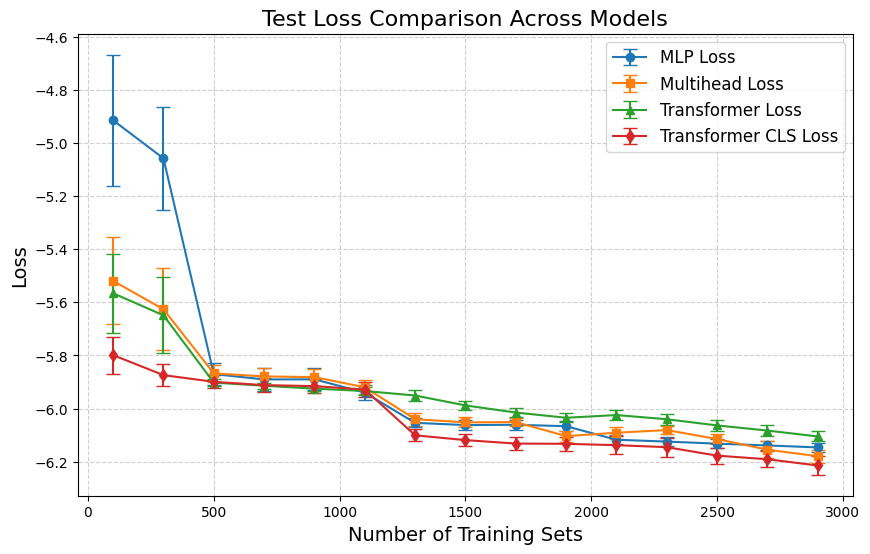

In [12]:
n_train_set = range(100, 3000, 200)
plt.figure(figsize=(10, 6))
plt.errorbar(n_train_set, loss_mlp['test_loss_mean_log'], yerr=loss_mlp['test_loss_std_log'] / np.sqrt(n_rep) , 
             label='MLP Loss', marker='o', capsize=5)
plt.errorbar(n_train_set, loss_multihead['test_loss_mean_log'], yerr=loss_multihead['test_loss_std_log'] /  np.sqrt(n_rep), 
             label='Multihead Loss', marker='s', capsize=5)
plt.errorbar(n_train_set, loss_transformer['test_loss_mean_log'], yerr=loss_transformer['test_loss_std_log'] /  np.sqrt(n_rep), 
             label='Transformer Loss', marker='^', capsize=5)
plt.errorbar(n_train_set, loss_transformer_cls['test_loss_mean_log'], yerr=loss_transformer_cls['test_loss_std_log']/ np.sqrt(n_rep), 
             label='Transformer CLS Loss', marker='d', capsize=5)

# Titles and labels
plt.title('Test Loss Comparison Across Models', fontsize=16)
plt.xlabel('Number of Training Sets', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Legend and grid
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()